------------
# Importing Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
import tensorflow as tf
import pickle

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from ipynb.fs.full.PreProcessing import get_moving_diff, rescaling, get_static_features

In [3]:
print(device_lib.list_local_devices())
config = tf.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9193228558117174590
]


---------------
# Loading Data into System

In [5]:
x_lstm_train = np.load(os.path.join('data', 'x_lstm_train.npy'))
x_lstm_test = np.load(os.path.join('data', 'x_lstm_test.npy'))

x_static_train = np.load(os.path.join('data', 'x_static_train.npy'))
x_static_test = np.load(os.path.join('data', 'x_static_test.npy'))

y_train = np.load(os.path.join('data', 'y_train.npy'))
y_test = np.load(os.path.join('data', 'y_test.npy'))

In [6]:
print(x_lstm_train.shape, x_lstm_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(35776, 120) (8944, 120)
(35776, 9) (8944, 9)
(35776, 6) (8944, 6)


# Re-Structuring the data

In [7]:
x_lstm_train = np.expand_dims(x_lstm_train, axis=-1)
x_lstm_test = np.expand_dims(x_lstm_test, axis=-1)

x_static_train = np.expand_dims(x_static_train, axis=-1)
x_static_test = np.expand_dims(x_static_test, axis=-1)

In [8]:
print(x_lstm_train.shape, x_lstm_test.shape)
print(x_static_train.shape, x_static_test.shape)
print(y_train.shape, y_test.shape)

(35776, 120, 1) (8944, 120, 1)
(35776, 9, 1) (8944, 9, 1)
(35776, 6) (8944, 6)


# Model Creation

In [9]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [10]:
# 32, 16, 30 
model = keras.Sequential()

lstm_input = layers.Input(shape=(x_lstm_train.shape[1], x_lstm_train.shape[2]))

lstm_stack_1, lstm_stack_1_c = layers.GRU(120, return_sequences=True, return_state=True)(lstm_input)

drop_2 = layers.Dropout(0.1)(lstm_stack_1_c)
dense_1 = layers.Dense(64)(drop_2)
drop_3 = layers.Dropout(0.05)(dense_1)
dense_2 = layers.Dense(16)(drop_3)
drop_4 = layers.Dropout(0.05)(dense_2)

output = layers.Dense(6)(drop_4)


model = models.Model(inputs=lstm_input, outputs=output)
model.summary()
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=[r_square,'mae']
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
gru (GRU)                    [(None, 120, 120), (None, 43920     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                7744      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_____________________________________________

In [12]:
checkpoint = ModelCheckpoint("model_gru_linear-{epoch:03d}.h5", monitor='r_square', verbose=1,
    save_best_only=False, save_weights_only=True, mode='auto', period=1)

history = model.fit(
    x_lstm_train, y_train,
    epochs=5,
    batch_size=48,
    verbose=1,
    validation_data=(x_lstm_test, y_test),
    shuffle=True,
    callbacks=[checkpoint]
)

Train on 35776 samples, validate on 8944 samples
Epoch 1/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.2757e-04 - r_square: 0.0679 - mean_absolute_error: 0.0171 
Epoch 00001: saving model to model_gru_linear-001.h5
35776/35776 [==============================] - 144s 4ms/sample - loss: 9.2735e-04 - r_square: 0.0679 - mean_absolute_error: 0.0171 - val_loss: 6.3742e-04 - val_r_square: 0.1082 - val_mean_absolute_error: 0.0152
Epoch 2/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.1929e-04 - r_square: 0.0772 - mean_absolute_error: 0.0169
Epoch 00002: saving model to model_gru_linear-002.h5
35776/35776 [==============================] - 152s 4ms/sample - loss: 9.1927e-04 - r_square: 0.0773 - mean_absolute_error: 0.0169 - val_loss: 6.3757e-04 - val_r_square: 0.1025 - val_mean_absolute_error: 0.0152
Epoch 3/5
35760/35776 [============================>.] - ETA: 0s - loss: 9.1550e-04 - r_square: 0.0869 - mean_absolute_error: 0.0169
Epoch 00003: saving mod

dict_keys(['loss', 'r_square', 'mean_absolute_error', 'val_loss', 'val_r_square', 'val_mean_absolute_error'])


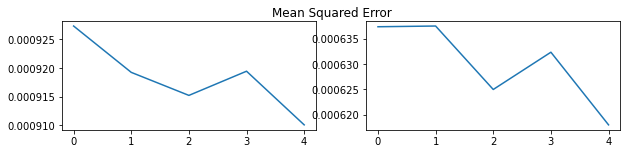

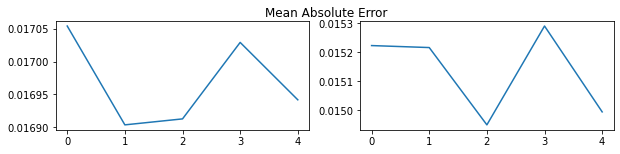

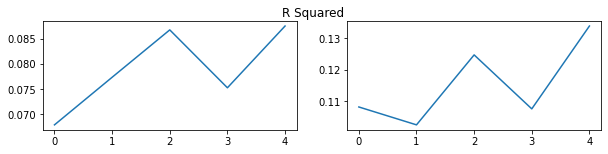

In [30]:
print(history.history.keys())

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig1.suptitle('Mean Squared Error')
ax1.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig2.suptitle('Mean Absolute Error')
ax1.plot(history.history['mean_absolute_error'])
ax2.plot(history.history['val_mean_absolute_error'])

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,2))
fig3.suptitle('R Squared')
ax1.plot(history.history['r_square'])
ax2.plot(history.history['val_r_square'])

In [ ]:
model.save(os.path.join('data','model_gru_single.h5'))

# Testing Prediction sequence

In [31]:
cgm_df = pd.read_csv(os.path.join('data','CGMData.csv')).T

In [32]:
testing_data = cgm_df.T.iloc[:,-450:-1].to_numpy()
testing_data

array([[101.,  92.,  87.,  85.,  81.,  79.,  80.,  80.,  81.,  82.,  78.,
         77.,  77.,  75.,  79.,  82.,  88.,  91.,  92.,  96., 101., 111.,
        120., 126., 134., 147., 154., 158., 163., 161., 147., 131., 124.,
        123., 124., 124., 124., 123., 124., 124., 129., 131., 128., 127.,
        125., 127., 135., 137., 147., 147., 143., 145., 146., 146., 147.,
        149., 150., 155., 163., 167., 169., 170., 171., 173., 180., 187.,
        190., 182., 177., 173., 161., 153., 143., 140., 141., 139., 140.,
        142., 130., 110., 110., 112., 117., 118., 116., 115., 114., 114.,
        114., 114., 115., 115., 116., 117., 118., 119., 119., 120., 120.,
        121., 121., 120., 120., 120., 122., 123., 123., 123., 122., 123.,
        124., 125., 126., 126., 125., 124., 123., 123., 123., 122., 120.,
        117., 116., 116., 117., 118., 118., 119., 120., 121., 122., 124.,
        124., 124., 125., 125., 125., 125., 124., 122., 121., 119., 118.,
        119., 123., 132., 139., 142., 

In [ ]:
model.load_weights('model_gru_linear-118.h5')

In [ ]:
scaler = pickle.load((open(os.path.join('data','scaler.pkl'), 'rb')))

time_stamps = 100
ahead_pred = 48
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
#    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = org_lstm
#    input_lstm = np.vectorize(rescaling)(input_lstm)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    
    pred = model.predict(input_lstm)[0,0]
#     pred = rescaling(pred[0,0], newscale=(-100,100), oldscale=(-1,1))
#     pred = org_lstm[:,-1]+pred
#     if pred[0] > int(pred[0])+0.5:
#         pred[0] = int(pred[0])+1.0
#     else:
#         pred[0] = int(pred[0])
        
#     y_pred.append(pred)
#     org_lstm = np.concatenate((org_lstm[:,1:], np.expand_dims(pred, axis=0)), axis=-1)

#     pred = rescaling(org_lstm[:,-1], newscale=(0,1), oldscale=(20,450)) + pred
#     pred = rescaling(pred, newscale=(20,450), oldscale=(0,1))
    
#     if pred > int(pred)+0.5:
#         pred = int(pred)+1.0
#     else:
#         pred = int(pred)
    
#     pred = np.reshape(pred, (1,1))
#     y_pred.append(pred)
#     org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

#    pred = org_lstm[:,-1] + pred
    
    if pred >= int(pred)+0.5:
        pred = int(pred)+1.0
    else:
        pred = int(pred)+0.0
    print(pred)
    pred = np.reshape(pred, (1,1))
    y_pred.append(pred)
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

In [34]:
scaler = pickle.load((open(os.path.join('data','scaler.pkl'), 'rb')))

time_stamps = 120
ahead_pred = 48
org_lstm = testing_data[:,0:time_stamps]
y_ground = testing_data[:,time_stamps:time_stamps+ahead_pred]

y_pred = []
for i in range(ahead_pred):
    input_lstm = get_moving_diff(org_lstm, replace_na=True)
    input_lstm = np.vectorize(rescaling)(input_lstm)
    
    input_static = get_static_features(org_lstm)
    input_static = scaler.transform(input_static)
    
    input_lstm = np.expand_dims(input_lstm, axis=-1)
    input_static = np.expand_dims(input_static, axis=-1)

    pred = model.predict(input_lstm)
    print(pred)
    pred=pred[0][0]
    pred = rescaling(pred, newscale=(-100,100), oldscale=(-1,1))
    pred = org_lstm[:,-1]+pred
    print(pred)
    
    if pred >= int(pred)+0.5:
         pred = int(pred)+1.0
    else:
         pred = int(pred)+0.0
    pred = np.reshape(pred, (1,1))
    y_pred.append(pred)
    org_lstm = np.concatenate((org_lstm[:,1:], pred), axis=-1)

[[ 0.00014756 -0.00079538 -0.00106152  0.00180726 -0.00133475 -0.0015948 ]]
[122.01475556]
[[ 0.0009804  -0.00032611 -0.00068044  0.00202915 -0.00114435 -0.00143936]]
[122.0980403]
[[ 0.00126582 -0.00014043 -0.00052617  0.00216017 -0.00102102 -0.0012955 ]]
[122.12658229]
[[ 1.3748189e-03 -5.4911026e-05 -4.4719223e-04  2.2376198e-03
  -9.4388757e-04 -1.2030937e-03]]
[122.13748189]
[[ 1.4413882e-03  3.8376602e-06 -3.8895675e-04  2.2932489e-03
  -8.8713528e-04 -1.1385924e-03]]
[122.14413882]
[[ 1.4970060e-03  5.3792013e-05 -3.3917301e-04  2.3384008e-03
  -8.4108941e-04 -1.0885266e-03]]
[122.1497006]
[[ 1.5454392e-03  9.7066135e-05 -2.9658212e-04  2.3758663e-03
  -8.0322521e-04 -1.0483084e-03]]
[122.15454392]
[[ 0.00158656  0.00013362 -0.00026105  0.00240656 -0.00077253 -0.00101612]]
[122.15865606]
[[ 0.00162078  0.00016389 -0.00023195  0.00243131 -0.00074802 -0.00099064]]
[122.16207793]
[[ 0.00164894  0.00018868 -0.00020835  0.00245105 -0.00072865 -0.00097066]]
[122.16489413]
[[ 0.0016719

In [ ]:
np.save('gru_linear_good.npy',y_pred)